In [3]:
import os
# file = os.path.join(os.getcwd(), 'data', 'LibriSpeech', 'dev-clean','84', '121123', '84-121123-0000.flac')
file ="C:\\Users\\Julio\\Documents\\Projects\\audio-denoiser\\data\\LibriSpeech\\dev-clean\\84\\121123\\84-121123-0000.flac"
testfile ="C:\\Users\\Julio\\Documents\\Projects\\audio-denoiser\\data\\test.wav"

import IPython.display as ipd

import numpy as np
ipd.Audio(filename=testfile)

In [18]:
import librosa
x, sr = librosa.load(testfile, sr=44100)
x.shape[0]*(1/sr)

2.0353968253968255

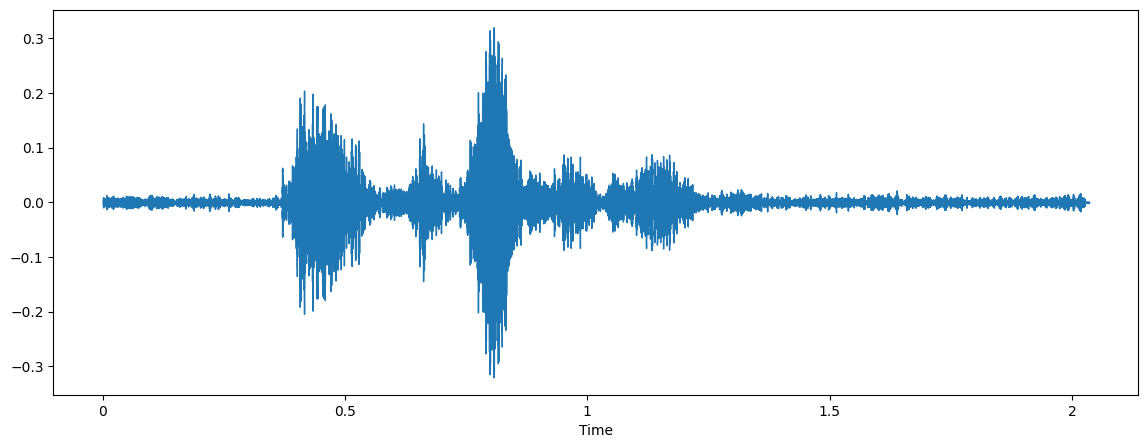

In [19]:
import matplotlib.pyplot as plt
import librosa.display
plt.figure(figsize=(14, 5))
librosa.display.waveshow(x, sr=sr)

In [20]:
# window size: num of samples in a window
# n_fft: num of samples considered in the DFT for each sample in the window
    # usually they are the same
# hop_length: num of samples between the start of consecutive windows
    # 50% to 75% of n_fft overlap is common
# num of frequency bins = n_fft/2 + 1
    # more bins = more resolution in the frequency domain = more samples per FFT (narrowband)
    # range of bins is [0, sr/2]
    # wideband usually preferred for speech analysis
X = librosa.stft(x, n_fft=1024, hop_length=512)
X.shape

(513, 176)

In [21]:
# X_2 = librosa.util.normalize(X, axis=1)  # Normalize the magnitude
inverted_audio = librosa.istft(X, hop_length=512, win_length=1024)
ipd.Audio(x, rate=sr)


In [22]:
print(max(inverted_audio))
print(max(x))
print(inverted_audio.shape)
print(x.shape)

0.3201021
0.3201021
(89600,)
(89761,)


numpy.complex64

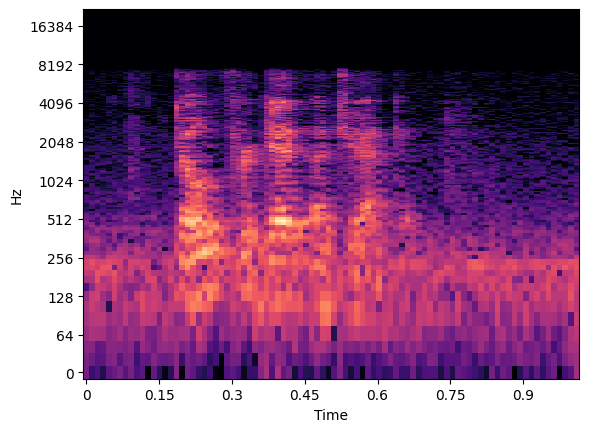

In [31]:
librosa.display.specshow(librosa.amplitude_to_db(X, ref=np.max), sr = sr, y_axis='log', x_axis='time')
Y = X
type(Y[0][1])


In [13]:
val = Y[5]
print(val)
print(abs(val))
# print(pow((val.real**2 + val.imag**2), 0.5))

[ 0.5118031 -5.00417233e-01j  0.25609148+8.06541264e-01j
 -1.0271081 -8.81690145e-01j  1.0965451 -6.61424518e-01j
 -0.87912196+2.53026396e-01j -0.17534815-1.47323930e+00j
  0.60233295-3.76977980e-01j -0.100903  +9.13401246e-02j
 -0.02992712+1.61374286e-02j -0.6041639 -6.26113832e-01j
  0.64719325-2.40017906e-01j -0.14204527-4.61697161e-01j
  0.60721475+6.19378202e-02j -0.09024655+5.88450611e-01j
 -1.2831578 +7.97516108e-02j -0.04794666-1.22576141e+00j
  0.9182107 +1.18901715e-01j -0.01420793+1.05089998e+00j
 -0.47068867-5.65581441e-01j  1.256278  +1.19387436e+00j
 -2.1133466 +8.27725470e-01j -0.54644984-8.73301387e-01j
 -0.61366314-1.12249076e+00j  1.1000274 -1.25835991e+00j
  1.3522608 +7.79185593e-01j -0.9838417 +5.61571240e-01j
  0.4657971 -9.99622703e-01j  0.94835174+5.42703629e-01j
  0.21423642+7.81824589e-01j -0.5591862 +5.14101624e-01j
 -0.7081507 -9.97312188e-01j  1.2373836 -1.50085092e-02j
 -1.145898  -3.29673946e-01j  1.4549806 +1.04213715e-01j
 -0.8631901 +7.35899210e-01j -2

In [29]:
# phase of val
phase = np.arctan2(val.imag, val.real)
phase

-0.15986265

In [35]:
val1 = Y[5][1]
val2 = Y[7][1]
print(val1 * val2)
_val = (val1.real*val2.real - val1.imag*val2.imag)+1j*(val1.real*val2.imag + val1.imag*val2.real)
print(_val)

(0.029063204-0.057134636j)
(0.029063204303383827-0.057134635746479034j)


In [ ]:
# Noise Estimation
# average past power spectra values on "silent" frames
# estimate_noise_ps(f,n) = alpha * estimate_noise_ps(f,n-1) + (1 - alpha) * noise_frame_ps(f,n)
# recursive defintion
# alpha is a smoothing factor [0,1], n is current frame and f is frequency bin from the stft

def estimate_noise_power(signal_power, noise_estimate, alpha=0.9):
    return alpha * noise_estimate + (1 - alpha) * signal_power
    


In [40]:
'''
    1. Frame Goes through WF to get the smoothed noise estimate
    2. smoothed noise estimate is inverted and copied to calculate the next WF
    3. smoothed noise estimate is subtracted from noisy frame and invterted to calc next WF
    4. smoothed noise estimated subtracted from noisy frame to get enahnced frame
'''
    
import webrtcvad
vad = webrtcvad.Vad()
class _AudioSuppressor:
    def __init__(self):
        self.alpha = 0.9
        self.noise_estimate = None
    # Y (k, n) k is frequency bin, n is frame
    # Y is mixed signal
    # X (k, n) is the estimated clean signal
    # N (k, n) is the estimated noise signal
    def denoise(self, Y):
        Y = np.abs(Y)
        # print('signal in ', Y)
        for n in range(Y.shape[1]):
            # H_n = np.zeros(Y.shape[1], dtype=np.complex)
            Y_n = np.reshape(Y[:, n], (Y.shape[0], 1))
            print(Y_n.shape)
            y_n = librosa.istft(Y_n, hop_length=512, win_length=1024)
            vad.is_speech(y_n, sample_rate=sr)
            print(Y_n.shape)
        return None

In [ ]:
# Wiener Filter
# H_wiener = (signal_power - noise_power )/ signal_power 
# final signal power spectra is then H_wiener * signal_power
# the final spectra is combined with the phase of the original.

In [41]:
class AudioSuppressor:
    def __init__(self):
        self.alpha = 0.9
        self.noise_estimate = None
    # Y (k, n) k is frequency bin, n is frame
    # Y is mixed signal
    # X (k, n) is the estimated clean signal
    # N (k, n) is the estimated noise signal
    def denoise(self, Y):
        Y = np.abs(Y)
        print('signal in ', Y)
        for n in range(Y.shape[1]):
            Y_n = Y[:, n]
            print(Y_n.shape)
        return None
    
AS = _AudioSuppressor()
# print(X.shape)
Y = X[:, 0:10]
# print(Y.shape)
# librosa.amplitude_to_db(Y, ref=np.max)
# librosa.display.specshow(data=librosa.amplitude_to_db(Y, ref=np.max), sr = sr, y_axis='log', x_axis='time')
AS.denoise(Y)
    

(513, 1)


Error: Error while processing frame